In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# read ohe & non-ohe versions of each dataset
data_lag = pd.read_csv('./data/safegraph_lag.csv.gz', compression='gzip')
data_nolag = pd.read_csv('./data/safegraph_no-lag.csv.gz', compression='gzip')
data_lag_ohe = pd.read_csv('./data/safegraph_lag_ohe.csv.gz', compression='gzip')
data_nolag_ohe = pd.read_csv('./data/safegraph_no-lag_ohe.csv.gz', compression='gzip')

# create "basic" dataset consisting only of target
data_basic = data_nolag[['week', 'change_in_visits', 'target']]

# read in non-OHE full datatset
data_full = pd.read_pickle("./data/full_dataset_with_features.csv.gz", compression='gzip')
data_full = data_full.dropna()

# create OHE version of full data
data_full_ohe = pd.get_dummies(data_full, \
    columns=[x for x in data_full.columns if x.startswith('naics_')])

# drop final dummy from each level (choose to drop 0s)
naics_0s = ['naics_{}_0'.format(x) for x in range(2,6)]
naics_0s.append('naics_code_0')
data_full_ohe.drop(columns=naics_0s, inplace=True)

print('Shape of non-OHE SafeGraph data without lag variables: ', data_nolag.shape)
print('Shape of OHE SafeGraph data without lag variables: ', data_nolag_ohe.shape)

print('Shape of non-OHE SafeGraph data with lag variables: ', data_lag.shape)
print('Shape of OHE SafeGraph data with lag variables: ', data_lag_ohe.shape)

print('Shape of non-OHE full dataset ', data_full.shape)
print('Shape of OHE full dataset: ', data_full_ohe.shape)


In [5]:
def LR(data, week=False, cap=None, ohe=True):
    '''
    Fit and evaluate linear regression on data
    '''

    # Set features, specify which ones to scale
    feature_cols = list(data.columns)
    non_features = ['postal_code', 'ZIP', 'ZIP_y', 'target']
    if week==False:
        non_features.append('week')
    for x in non_features:
        if x in feature_cols:
            feature_cols.remove(x)
    if ohe:
        scale_cols = [x for x in feature_cols if not x.startswith('naics_')]
    else:
        scale_cols = feature_cols

    # Make week 15 the test set
    test_data = data[data['week']==15].copy()
    X_test = test_data[feature_cols]
    y_test = test_data['target']
    if cap:
        y_test = y_test.apply(lambda x: min(x, cap))

    # Make week 14 the validation set
    val_data = data[data['week']==14].copy()
    X_val = val_data[feature_cols]
    y_val = val_data['target']
    if cap:
        y_val = y_val.apply(lambda x: min(x, cap))

    # Make train everything else
    train_data = data[data['week']<14].copy()
    X_train = train_data[feature_cols]
    y_train = train_data['target']
    if cap:
        y_train = y_train.apply(lambda x: min(x, cap))

    del(test_data,val_data,train_data)

    # Scale everything based on X_train
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_train[scale_cols])
    X_train[scale_cols] = scaler.transform(X_train[scale_cols])
    X_val[scale_cols] = scaler.transform(X_val[scale_cols])
    X_test[scale_cols] = scaler.transform(X_test[scale_cols])

    # Fit model
    reg = LinearRegression().fit(X_train, y_train)

    # Evaluation
    pred_train = reg.predict(X_train)
    pred_val = reg.predict(X_val)
    
    r2_train = r2_score(y_train, pred_train)
    r2_val = r2_score(y_val, pred_val)
    print('Training set r2: ', r2_train)
    print('Validation set r2: ', r2_val)
    print('\n')
    
    mse_train = mean_squared_error(y_train, pred_train)
    mse_val = mean_squared_error(y_val, pred_val)
    print('Training set MSE: ', mse_train)
    print('Validation set MSE: ', mse_val)
    print('\n')
    
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_val = mean_absolute_error(y_val, pred_val)
    print('Training set MAE: ', mae_train)
    print('Validation set MAE: ', mae_val)
    print('\n')
    
    train_results = pd.DataFrame(data={'Train R2':[r2_train], 
                                       'Train MSE':[mse_train], 
                                       'Train MAE':[mae_train]})

    val_results = pd.DataFrame(data={'Val R2':[r2_val], 
                                       'Val MSE':[mse_val], 
                                       'Val MAE':[mae_val]})
    
    
    return train_results, val_results

In [ ]:
# set caps to test
caps = [None, 100, 10, 5, 2, 1]

# initialize empty results frames
train_results = pd.DataFrame()
val_results = pd.DataFrame()

for cap in caps:
    
    # LR with only one variable
    print('Linear regression on previous target, cap={}\n'.format(cap))
    basic_train, basic_val = LR(data_basic, cap=cap, week=False, ohe=False)
    
    print('-------------------------------------------------------------\n')

    # LR on SG with no lag
    print('Linear regression on SafeGraph data without lag variables, cap={}\n'.format(cap))
    nolag_train, nolag_val = LR(data_nolag, cap=cap, week=False, ohe=False)
    
    print('-------------------------------------------------------------\n')
    
    # LR on SG with no lag, OHE
    print('Linear regression on OHE SafeGraph data without lag variables, cap={}\n'.format(cap))
    nolag_ohe_train, nolag_ohe_val = LR(data_nolag_ohe, cap=cap, week=False, ohe=True)
    
    print('-------------------------------------------------------------\n')

    # LR on SG with lag
    print('Linear regression on SafeGraph data with lag variables, cap={}\n'.format(cap))
    lag_train, lag_val = LR(data_lag, cap=cap, week=False, ohe=False)
    
    print('-------------------------------------------------------------\n')
    
    # LR on SG with lag, OHE
    print('Linear regression on OHE SafeGraph data with lag variables, cap={}\n'.format(cap))
    lag_ohe_train, lag_ohe_val = LR(data_lag_ohe, cap=cap, week=False, ohe=True)
    
    print('-------------------------------------------------------------\n')
    
    # LR on full data without week
    print('Linear regression on full data without week, cap={}\n'.format(cap))
    fullnoweek_train, fullnoweek_val = LR(data_full, cap=cap, week=False, ohe=False)
    
    print('-------------------------------------------------------------\n')
    
    # LR on full data without week, OHE
    print('Linear regression on OHE full data without week, cap={}\n'.format(cap))
    fullnoweek_ohe_train, fullnoweek_ohe_val = LR(data_full_ohe, cap=cap, week=False, ohe=True)
    
    print('-------------------------------------------------------------\n')
    
    # LR on full data with week
    print('Linear regression on full data with week, cap={}\n'.format(cap))
    fullweek_train, fullweek_val = LR(data_full, cap=cap, week=True, ohe=False)
    
    print('-------------------------------------------------------------\n')
    
    # LR on full data with week, OHE
    print('Linear regression on OHE full data with week, cap={}\n'.format(cap))
    fullweek_ohe_train, fullweek_ohe_val = LR(data_full_ohe, cap=cap, week=True, ohe=True)
    
    print('-------------------------------------------------------------\n')
    

        
    # create list of results dataframes
    train_dfs = [basic_train, 
                 nolag_train, nolag_ohe_train, 
                 lag_train, lag_ohe_train, 
                 fullnoweek_train, fullnoweek_ohe_train, 
                 fullweek_train, fullweek_ohe_train]
    
    val_dfs =  [basic_val, 
                nolag_val, nolag_ohe_val, 
                lag_val, lag_ohe_val, 
                fullnoweek_val, fullnoweek_ohe_val, 
                fullweek_val, fullweek_ohe_val]
    
    # create list of lists
    df_lists = [train_dfs, val_dfs]
    
    # create list of dataset names
    data_list = ['Previous target only', 
                 'SG without lag', 'SG without lag', 
                 'SG with lag', 'SG with lag',
                 'Full dataset without week', 'Full dataset without week',
                 'Full dataset with week', 'Full dataset with week']
    
    ohe_list = ['Not applicable', 
                'No', 'Yes', 
                'No', 'Yes', 
                'No', 'Yes',
                'No', 'Yes']
        
    # set captag
    if cap==None:
        captag = 'No cap'
    else:
        captag = 'Cap={}'.format(cap)  
        
    # set multi-index
    for df_list in df_lists:
        for i, df in enumerate(df_list):
            df['Outlier Cap'] = captag
            df['One-Hot Encoding'] = ohe_list[i]
            df['Dataset'] = data_list[i]
            df.set_index(['Outlier Cap', 'One-Hot Encoding', 'Dataset'], inplace=True) 
    
    # concatenate results
    train_results = pd.concat([train_results] + train_dfs)
    val_results = pd.concat([val_results] + val_dfs)
    

Linear regression on OHE full data without week, cap=5



In [1]:
print('\nTraining Set Results:')
display(train_results)



Training Set Results:


NameError: name 'train_results' is not defined

In [ ]:
print('\nValidation Set Results:')
display(val_results)

In [9]:
# view best-performing datasets at each cap level
pd.DataFrame(data={"Best Val R2":\
                     ['SG with lag', 'SG with lag', 'SG with lag', 
                      'SG with lag', 'SG with lag', 'SG with lag'], 
                   "Best Val MSE":\
                     ['Full dataset', 'Full dataset', 'SG with lag', 
                      'SG with lag', 'SG with lag', 'Full dataset'], 
                   "Best Val MAE":\
                     ['Previous target only', 'SG with lag', 'SG with lag', 
                      'SG with lag', 'SG with lag', 'SG with lag']}, 
             index=['No cap', 'Cap=100', 'Cap=10', 'Cap=5', 'Cap=2', 'Cap=1'])

,Best Val R2,Best Val MSE,Best Val MAE
No cap,SG with lag,Full dataset,Previous target only
Cap=100,SG with lag,Full dataset,SG with lag
Cap=10,SG with lag,SG with lag,SG with lag
Cap=5,SG with lag,SG with lag,SG with lag
Cap=2,SG with lag,SG with lag,SG with lag
Cap=1,SG with lag,Full dataset,SG with lag


In [11]:
# View target distribution with different outlier caps

nocap = pd.DataFrame(data_full.target.describe()[1:]).T
nocap['Cap on Outliers'] = 'None'
nocap.set_index('Cap on Outliers', inplace=True)

captable = nocap
caps = [100, 10, 5, 2, 1]
for cap in caps:
    dropped['target'] = dropped['target'].apply(lambda x: min(x, cap))
    df = pd.DataFrame(dropped.target.describe()[1:]).T
    df['Cap on Outliers'] = cap
    df.set_index('Cap on Outliers', inplace=True)
    captable = pd.concat([captable, df])
captable

,mean,std,min,25%,50%,75%,max
Cap on Outliers,,,,,,,
None,-0.393399,3.014309,-0.998963,-0.854369,-0.693182,-0.416667,564.0
100,-0.541941,0.463714,-0.998963,-0.854369,-0.693182,-0.416667,1.0
10,-0.541941,0.463714,-0.998963,-0.854369,-0.693182,-0.416667,1.0
5,-0.541941,0.463714,-0.998963,-0.854369,-0.693182,-0.416667,1.0
2,-0.541941,0.463714,-0.998963,-0.854369,-0.693182,-0.416667,1.0
1,-0.541941,0.463714,-0.998963,-0.854369,-0.693182,-0.416667,1.0


In [19]:
outliers = []
for i in range(int(data_full.target.max()+1)):
    outliers.append(np.sum(data_full['target']>i))

In [20]:
np.sum(data_full['target']>5)

1665

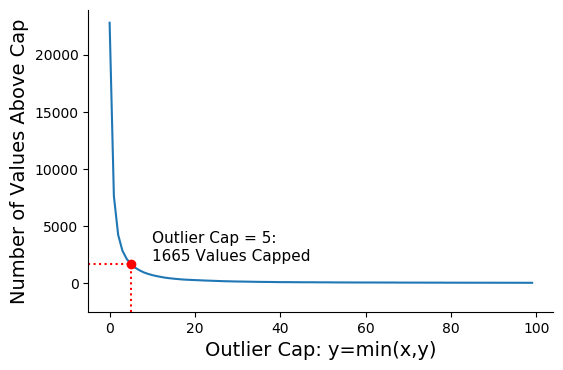

In [91]:
from matplotlib import collections  as mc

fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.plot(np.arange(int(data_full.target.max())+1)[:100], outliers[:100])
plt.ylim(bottom=-2500)
plt.xlim(left=-5)
ax.plot(5,1665,'ro')
ax.vlines(x=5, ymin=-2500, ymax=1665, linestyle='dotted', color='red')
ax.hlines(y=1665, xmin=-5, xmax=5, linestyle='dotted', color='red', 
          label='Outlier Cap = 5:\n1665 Values Capped')

ax.set_xlabel('Outlier Cap: y=min(x,y)', fontsize=14)
ax.set_ylabel('Number of Values Above Cap', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.legend(loc='center', fontsize=12, frameon=False, bbox_to_anchor=(0.3, 0.3), handlelength=1)
ax.text(x=10, y=2000, s='Outlier Cap = 5:\n1665 Values Capped', fontsize=11)
plt.show()
